In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsp
from statsmodels.tsa.stattools import adfuller

In [ ]:
!wget -q -O exportdb https://docs.google.com/spreadsheets/d/e/2PACX-1vTe_eq-9FI_2JNF-BihtAi-Tme1WMWqomZ2WtSoYE-WXziDYd_qKNVxSt8AcAeb0O3baphoy7eR6FN0/pub?output=xlsx

In [ ]:
oecd = pd.read_excel('exportdb', decimal=',', sheet_name='real OECD')
oecd = oecd.set_index('Date')

nonoecd = pd.read_excel('exportdb', decimal=',', sheet_name='real non-OECD')
nonoecd = nonoecd.set_index('Date')

# Первичный анализ 👀

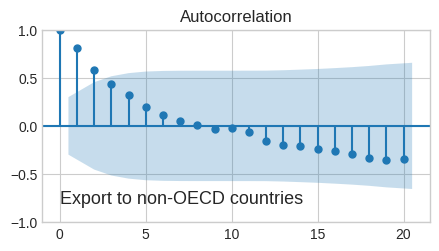

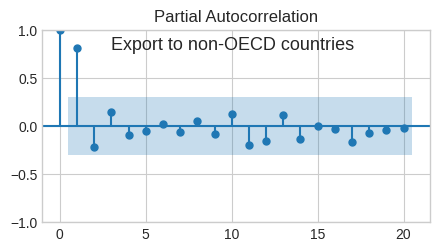

In [ ]:
mpl.rc("figure", figsize=(5,2.5))
tsp.plot_acf(x=nonoecd.iloc[:, 1], lags=20, alpha=0.05)
plt.text(0, -0.8, 'Export to non-OECD countries', fontsize=13)

tsp.plot_pacf(x=nonoecd.iloc[:, 1], lags=20, alpha=0.05)
plt.text(3, 0.8, 'Export to non-OECD countries', fontsize=13)
plt.show()

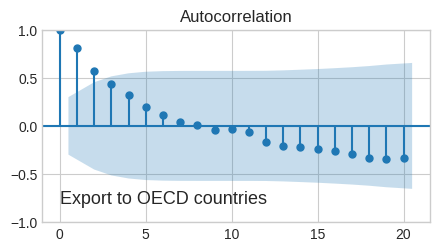

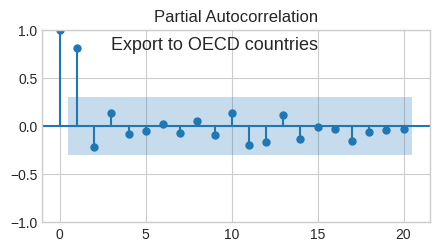

In [ ]:
mpl.rc("figure", figsize=(5,2.5))
tsp.plot_acf(x=oecd.iloc[:, 1], lags=20, alpha=0.05)
plt.text(0, -0.8, 'Export to OECD countries', fontsize=13)

tsp.plot_pacf(x=oecd.iloc[:, 1], lags=20, alpha=0.05)
plt.text(3, 0.8, 'Export to OECD countries', fontsize=13)
plt.show()

In [ ]:
print(f'p-value теста Дики-Фулера для экспорта в ОЭСР = {adfuller(oecd.iloc[:, 1])[1]}')
print(f'p-value теста Дики-Фулера для экспорта вне ОЭСР = {adfuller(nonoecd.iloc[:, 1])[1]}')
print(f'p-value теста Дики-Фулера цен нефти Aram Light = {adfuller(nonoecd.iloc[:, 0])[1]}')

p-value теста Дики-Фулера для экспорта в ОЭСР = 0.08086052006242583
p-value теста Дики-Фулера для экспорта вне ОЭСР = 0.9457774475955961
p-value теста Дики-Фулера цен нефти Aram Light = 0.3336209227877743


Наблюдаемые процессы автокоррелируют в малом окне, то есть их можно моделировать либо скалярно МА(m), где m - окно значимой автокорреляции, либо векторно VAR(n)/VECM(n), где n - окно значимой частичной автокорреляции.

Более того, так как ряды нестационарны, то нельзя использовать VAR, но и на этом не все, процессы экспорта и цены на нефть ко-интегрированы, то есть их линейная комбинация стационарна. Это можно увидеть на их графике, который я убрал, но в это можно поверить и исходя из экономической теории, ведь предложение очень сильно зависит от цены.

В такой ситуации необходимо использовать VECM, он также позволит учесть долгосрочную трендовую взаимосвязь процессов, что как раз нам и нужно.

# VECM? VECM! ♿

In [ ]:
from statsmodels.tsa.vector_ar.vecm import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:
rank_test = select_coint_rank(oecd, 0, 3, method="trace", signif=0.05)
rank_test.rank

2

Параметры глубины авторегрессии и спецификации тренда заданы подбором с целью соответствия теоретической предпосылке о сильной значимой зависимости экспорта нефти от ее цены.

In [ ]:
model = VECM(oecd, deterministic="lo", k_ar_diff=3,
             coint_rank=rank_test.rank).fit()
print(model.summary())

              Det. terms outside the coint. relation & lagged endog. parameters for equation Price of Arab light crude oil, дол.              
                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
lin_trend.Price of Arab light crude oil, дол                                   0.7897      0.524      1.508      0.132      -0.237       1.816
L1.Price of Arab light crude oil, дол..Price of Arab light crude oil, дол      0.7032      0.382      1.842      0.065      -0.045       1.451
L1.Export to OECD, млн. долл.Price of Arab light crude oil, дол               -0.0003      0.000     -1.748      0.080      -0.001     3.7e-05
L1.GDP per capita OECD, дол.Price of Arab light crude oil, дол                 0.0065      0.003      2.241      0.025       0.001       0.012

In [ ]:
rank_testnon = select_coint_rank(nonoecd, 0, 3, method="trace", signif=0.05)
rank_testnon.rank

1

In [ ]:
modelnon = VECM(nonoecd, deterministic="co", k_ar_diff=5,
                coint_rank=rank_testnon.rank).fit()
print(modelnon.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation Price of Arab light crude oil
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               28.5235     15.111      1.888      0.059      -1.093      58.140
L1.Price of Arab light crude oil     0.5783      0.303      1.911      0.056      -0.015       1.171
L1.Export to non-OECD               -0.0012      0.000     -3.727      0.000      -0.002      -0.001
L1.GDP per capita non-OECD           0.0743      0.021      3.544      0.000       0.033       0.115
L2.Price of Arab light crude oil     0.6076      0.310      1.959      0.050      -0.000       1.215
L2.Export to non-OECD               -0.0006      0.000     -1.559      0.119      -0.001       0.000
L2.GDP per capita non-OECD          -0.0191      0.023     -0.845      0.398      -

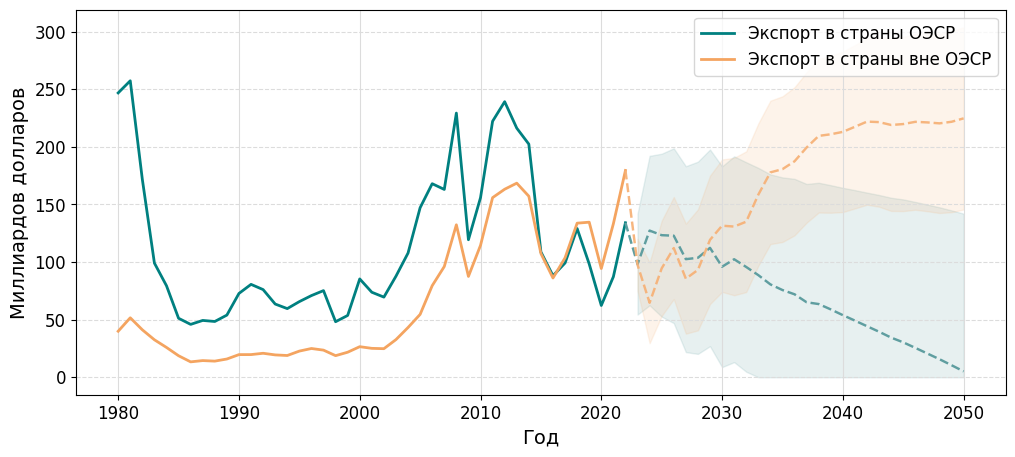

In [ ]:
fc = model.predict(steps=28, alpha=0.1)
y_hat = fc[0][:, 1]
y_hat = np.insert(y_hat, 0, oecd.iloc[-1, 1])
lower_series = fc[1][:, 1]
lower_series[lower_series < 0] = 0
upper_series = fc[2][:, 1]

fcnon = modelnon.predict(steps=28, alpha=0.1)
y_hatnon = fcnon[0][:, 1]
y_hatnon = np.insert(y_hatnon, 0, nonoecd.iloc[-1, 1])
lower_seriesnon = fcnon[1][:, 1]
lower_seriesnon[lower_seriesnon < 0] = 0
upper_seriesnon = fcnon[2][:, 1]

years = np.arange(oecd.index[-1] + 1, oecd.index[-1] + 28 + 1, 1)
yyears = np.arange(oecd.index[-1], oecd.index[-1] + 28 + 1, 1)

plt.figure(figsize=[12, 5])

plt.plot(oecd.iloc[:, 1]/1000, color='teal',
         label='Экспорт в страны ОЭСР', linewidth=2)
plt.plot(yyears, y_hat/1000, color='cadetblue', linestyle='--', linewidth=1.75)
plt.fill_between(years, lower_series/1000, upper_series/1000,
                 color='cadetblue', alpha=.15)

plt.plot(nonoecd.iloc[:, 1]/1000, color='sandybrown',
         label='Экспорт в страны вне ОЭСР', linewidth=2)
plt.plot(yyears, y_hatnon/1000, color='#f6b278', linestyle='--',
         linewidth=1.75, alpha=0.95)
plt.fill_between(years, lower_seriesnon/1000, upper_seriesnon/1000,
                 color='#f6b278', alpha=.15)


plt.xlabel('Год', fontsize = 14, color='black')
plt.ylabel('Миллиардов долларов', fontsize = 14, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='gainsboro')
plt.grid(axis ='y', which='major', linestyle='--', color='gainsboro')
plt.tick_params(axis='x', labelsize=12, color='black')
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=12)

plt.savefig('img.png', dpi=1000)